# Installing the Cheminformatics Package

To install the package, follow the instructions [here](https://github.com/vjb-collab/cheminformatics-bq). The installation script creates remote functions that can be called directly from BigQuery. With remote functions capabilities, common cheminformatics libraries can be integrated into  BigQuery workflows. This package integrates functions from the RDKit and Biopython libraries, but any library that can have its functionality exposed as a cloud function is a candidate for remote functions.

There are a number of configurable parameters that govern the behavior of cloud functions and remote functions. The behavior of each cloud function can be modified by adjusting the memory, timeout, maximum number of instances, etc., Remote function behavior can be modified by changing options like the value of max_batching_rows. For more details on configuring cloud functions, see [Configuring Cloud Functions](https://cloud.google.com/functions/docs/configuring). For more details on remote function behavior, see [Working with Remote Functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/remote-functions) 

# Labels

The installation script attaches labels to the cloud functions that are executed as remote functions. These labels are metadata pairs that can be used to organize resources at scale. For example, you can use labels to [Use labels to gain visibility into GCP resource usage and spending](https://cloud.google.com/blog/topics/cost-management/use-labels-to-gain-visibility-into-gcp-resource-usage-and-spending). The installation script adds three labels to each cloud function (i.e., package, function_type, and software_package). You can also add additional labels. 

# Remote Function Pricing

[Remote function pricing](https://cloud.google.com/bigquery/docs/reference/standard-sql/remote-functions#pricing) in based on standard [BigQuery Pricing](https://cloud.google.com/bigquery/pricing) and costs incurred from running [Cloud Functions](https://cloud.google.com/functions/pricing) and [Cloud Run](https://cloud.google.com/run/pricing). 

# Calling Remote Functions in BigQuery

Remote functions can be called just like any other function directly in your SQL queries. Throughout this notebook, we'll use _BigQuery Magic_ which allows you to run BigQuery SQL queries directly from a Jupyter Notebook. You can also use remote functions when you connect to BigQuery using any of the [BigQuery client libraries](https://cloud.google.com/bigquery/docs/reference/libraries). 

This is a simple example of using BigQuery Magic to invoke a standard SQL statement:

In [25]:
%%bigquery

SELECT CURRENT_DATE() AS the_date;


Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.93s/rows]


,the_date
0,2022-08-30


And another example where we assign query results directly to a dataframe.

In [26]:
%%bigquery df

SELECT CURRENT_DATE() AS the_date;


Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.11s/rows]


In [27]:
df

,the_date
0,2022-08-30


# Examples Illustrating the Cheminformatics Functions

## Converting SMILES to INCHI using RDKit

Let's say you have SMILES strings and need to convert them to INCHI. You can use the **rdkit_smiles_to_inchi** function and call it just like any other BigQuery function.

In [30]:
%%bigquery

select cheminformatics.rdkit_smiles_to_inchi("CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5") as inchi

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.16s/rows]


,inchi
0,InChI=1S/C29H31N7O/c1-21-5-10-25(18-27(21)34-2...


## Translating Nuceotide Sequences to Protein Sequences using Biopython

In this example, we pass a nucleotide sequence (mRNA) to two remote functions from the Biopython package -- **biopython_sequence_translate** which translates the entire sequence, and **biopython_sequence_translate_to_stop** which translates until identifying a stop codon.

In [35]:
%%bigquery --params {"mRNA":"gtatctagaagaaagaacgatgcggctcccacgtgcaaactctctaagaattacactgtttgtccatgagcgcgctacaatgatatcggtccctcgcctccacaaccgggacttgctttatgcgggctccagctgattgagacatagtgagcctcacaactgcgtcgccttcacgccgcagctggagcggtaaaagtttaactattactacagtcgggtcatgactttgtccaggactacgcctatgggtcc"}

SELECT 
`cheminformatics.biopython_sequence_translate`(@mRNA) as amino_acid_literal,
`cheminformatics.biopython_sequence_translate_to_stop`(@mRNA) as amino_acid_translated;



Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.96s/rows]


,amino_acid_literal,amino_acid_translated
0,VSRRKNDAAPTCKLSKNYTVCP*ARYNDIGPSPPQPGLALCGLQLI...,VSRRKNDAAPTCKLSKNYTVCP


# Calculating Molecular Descriptors and Fingerprints using RDKit

The RDKit can calculate many molecular descriptors and different types of molecular fingerprints. Molecular descriptors can be calculated using the **rdkit_molecular_descriptors** function and molecular fingerprints can be calculated using the **rdkit_fingerprint** function. You can see the source code for these functions by navigating to the Cloud Function UI in the Cloud Console. 

The molecular descriptors and molecular fingerprint functions return multiple values that are collected in a simple JSON object. The specific values can be extracted using [BigQuery JSON functions](https://cloud.google.com/bigquery/docs/reference/standard-sql/json_functions).

In [3]:
%%bigquery df --params {"smiles":"CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5"}

SELECT
cheminformatics.rdkit_fingerprint(@smiles) as fp,
cheminformatics.rdkit_molecular_descriptors(@smiles) as md

Downloading: 100%|██████████| 1/1 [00:02<00:00,  2.23s/rows]


To see the molecular descriptors that were calculated, you can view the json

In [27]:
import json
t = json.loads(df["md"][0])
print(json.dumps(t, indent=4, sort_keys=True))

{
    "BalabanJ": 1.235299560402864,
    "BertzCT": 1350.5562649808833,
    "ExactMolWt": 493.2590086120001,
    "FractionCSP3": 0.2413793103448276,
    "HallKierAlpha": -4.14,
    "HeavyAtomCount": 37,
    "HeavyAtomMolWt": 462.36700000000025,
    "MaxAbsPartialCharge": 0.3238440024866884,
    "MaxPartialCharge": 0.2551591618569856,
    "MolLogP": 4.590320000000003,
    "MolMR": 146.8938999999998,
    "MolWt": 493.61500000000024,
    "NHOHCount": 2,
    "NOCount": 8,
    "NumAliphaticCarbocycles": 0,
    "NumAliphaticHeterocycles": 1,
    "NumAliphaticRings": 1,
    "NumAromaticCarbocycles": 2,
    "NumAromaticHeterocycles": 2,
    "NumAromaticRings": 4,
    "NumHAcceptors": 7,
    "NumHDonors": 2,
    "NumHeteroatoms": 8,
    "NumRadicalElectrons": 0,
    "NumRotatableBonds": 7,
    "NumSaturatedCarbocycles": 0,
    "NumSaturatedHeterocycles": 1,
    "NumSaturatedRings": 1,
    "NumValenceElectrons": 188
}


If you wanted to extract, say, the molecular weight from the molecular descriptor calculation you can extract it

In [28]:
%%bigquery --params {"smiles":"CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5"}

SELECT
CAST(JSON_VALUE( cheminformatics.rdkit_molecular_descriptors(@smiles), "$.ExactMolWt") as FLOAT64 ) 

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.90s/rows]


,f0_
0,493.259009


Since the **rdkit_molecular_descriptors** function calculates 20+ different descriptors, if you are only interested in a few of them, then it would be more efficient to create a new remote function that calculates only those values. Parsing the molecular descriptor JSON is illustrated in the section  "Fingerprinting and Molecular Descriptors".

# Using the Cheminformatics Functions with a Compound Registry

The above examples illsutrate the basics of working with remote functions and calling the cheminformatics functions on simple data. Now, we will walk through running these functions at scale across a compound registry (a collection of compounds in a table). 

## Creating a Compound Registry

We'll create a compound registry to work with by selecting a subset of the [SAVI](https://www.nature.com/articles/s41597-020-00727-4) publically available dataset. You can explore the dataset in BigQuery by navigating to nih-nci-cbiit-chem-prod.savi.plus.  

First, create a dataset to store some of the intermediate tables.

In [30]:
%%bigquery

CREATE SCHEMA IF NOT EXISTS exports

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 915.19query/s] 


""


The SAVI dataset contains over 1 billion molecules. We'll work with 1% of it by using [Table Sampling](https://cloud.google.com/bigquery/docs/table-sampling). Sampling returns a variety of records while avoiding the costs associated with scanning and processing an entire table. We will also create a partitioned table as part of the query. Partitioning the table will increase the degree of parallelism when running the remote functions. We could partition the table in many ways, but here we'll distribute the data randomly across 4,000 partitions (the maximum number of partitions per table). This query will process ~ 580 MB and the resulting table will be roughly 700 MB and contain ~ 10 million compounds.

In [ ]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE TABLE
  exports.savi_smiles (smiles STRING,
    bin_id INT64)
PARTITION BY
  RANGE_BUCKET(bin_id, GENERATE_ARRAY(0, 3999, 1)) AS
SELECT
  product_smiles AS smiles,
  CAST(FLOOR(3999*RAND()) AS INT64) AS bin_id
FROM
  `nih-nci-cbiit-chem-prod.savi.plus` TABLESAMPLE SYSTEM (1 PERCENT)

## Calculating Molecular Fingerprints for Similarity and Substructure Search

We now have a table named _exports.savi_smiles_ that contains ~ 10 million compounds. In order to calculate fingerprints for each compound, we'll use the **rdkit_fingerprint** function which calculates both Morgan and Pattern Fingerprints. I have set the maximum number of instances for the **rdkit_fingerprint** function to 1,000 to take advantage of the scalability of the remote functions. This query will process ~ 580 MB.

In [57]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE TABLE
  `exports.savi_smiles_fp_json` AS (
  SELECT
    smiles,
    `cheminformatics.rdkit_fingerprint`(smiles) AS fingerprint_json,
  FROM
    `exports.savi_smiles` );

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1353.73query/s]                        

1min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In about one minute, we've calculated Morgan and Pattern fingerprints for 10 million molecules. The resulting table has two columns, the SMILES string and the fingerprint information as a JSON object. This is a preview of the data from the BigQuery Console:

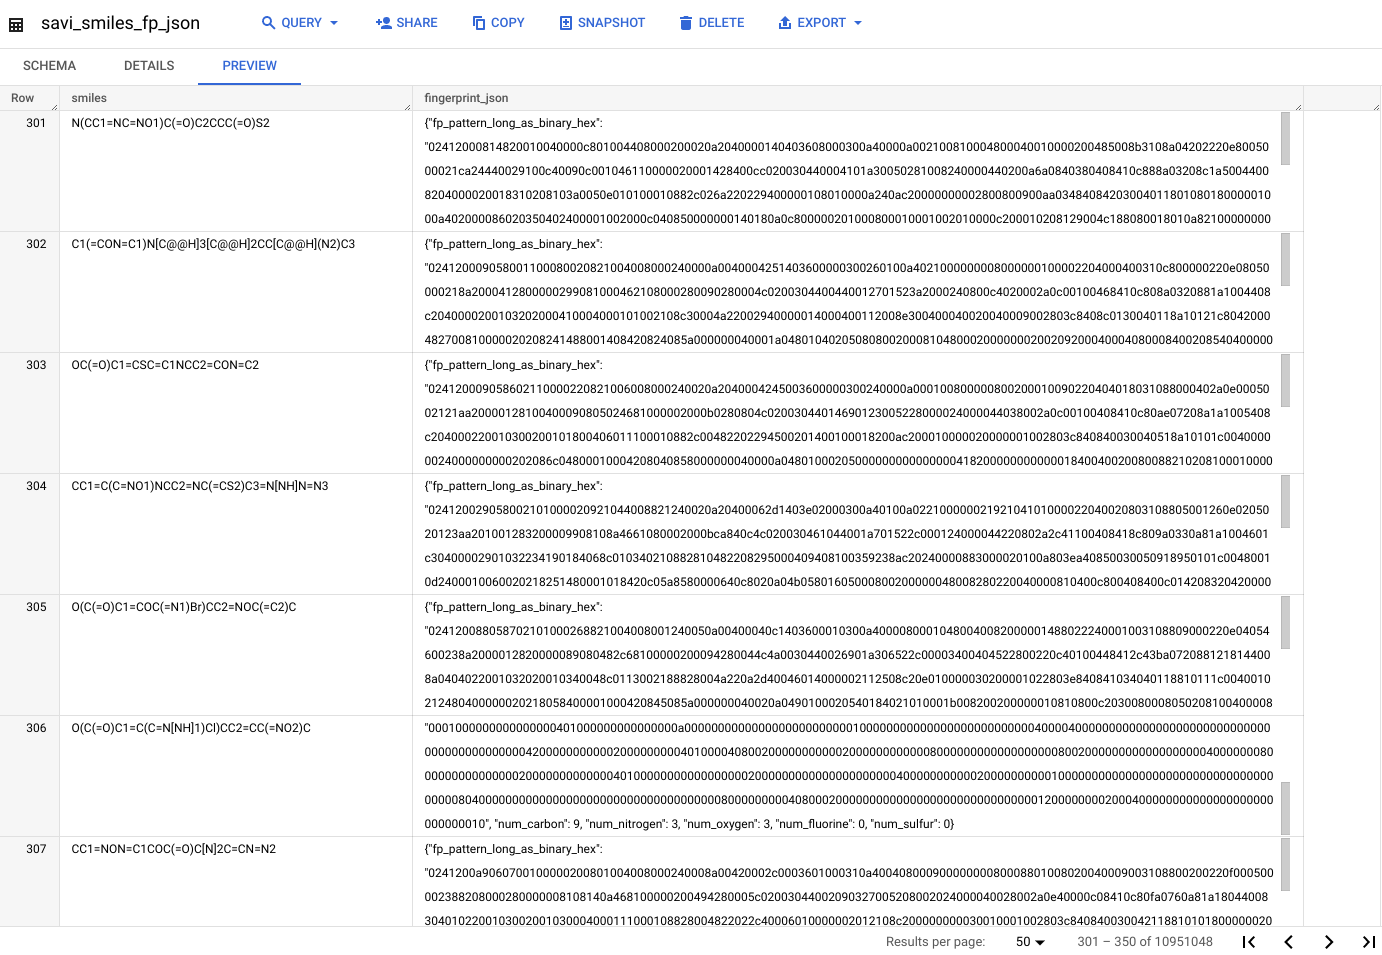

The fingerprint information is returned as a hex encoding of a raw bytes. So in the next step, we'll parse the fingerprints and create the final table. The **rdkit_fingerprint** function also returns the number of carbons, nitrogens, oxygens, fluorines and sulfurs. This is useful for partitioning and clustering the table when you can use these fields in WHERE clauses in your queries. That will lead to more efficient and less costly queries. Depending on your query pattern, you might choose to partition and cluster on different fields. You can calculate them separately or you can modify the **rdkit_fingerprint** function to calculate them. Also, some of the SAVI database has ill-defined SMILES strings which are returned as empty JSON objects, so we filter those out.

We will partition on the number of carbons, and I know ahead of time that all the compounds in the registry contain less than 100 carbons. In practice, if you are partitioning on number of carbons, you could normalize the data first, find the maximum number of carbons, and then partition as a second step in the workflow. But here, we'll do it all at once. 

This query will process ~ 12 GB of data 

In [58]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE TABLE
  exports.savi_smiles_fp_part_and_cluster
PARTITION BY
  RANGE_BUCKET(num_carbon, GENERATE_ARRAY(0, 100,1))
CLUSTER BY
  num_nitrogen,
  num_oxygen,
  num_fluorine,
  num_sulfur AS
SELECT
  smiles,
  FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_pattern_long_as_binary_hex')) AS fp_pattern_as_binary,
  FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_morgan_as_binary_hex')) AS fp_morgan_as_binary,
  CAST(JSON_VALUE(fingerprint_json, "$.num_carbon") AS INT64) AS num_carbon,
  CAST(JSON_VALUE(fingerprint_json, "$.num_oxygen") AS INT64) AS num_oxygen,
  CAST(JSON_VALUE(fingerprint_json, "$.num_nitrogen") AS INT64) AS num_nitrogen,
  CAST(JSON_VALUE(fingerprint_json, "$.num_fluorine") AS INT64) AS num_fluorine,
  CAST(JSON_VALUE(fingerprint_json, "$.num_sulfur") AS INT64) AS num_sulfur
FROM
  exports.savi_smiles_fp_json
WHERE
  fingerprint_json != ""

Query complete after 0.00s: 100%|██████████| 5/5 [00:00<00:00, 2146.96query/s]                        

20.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Below is a preview of the table we just created from the BigQuery UI in the Cloud Console:

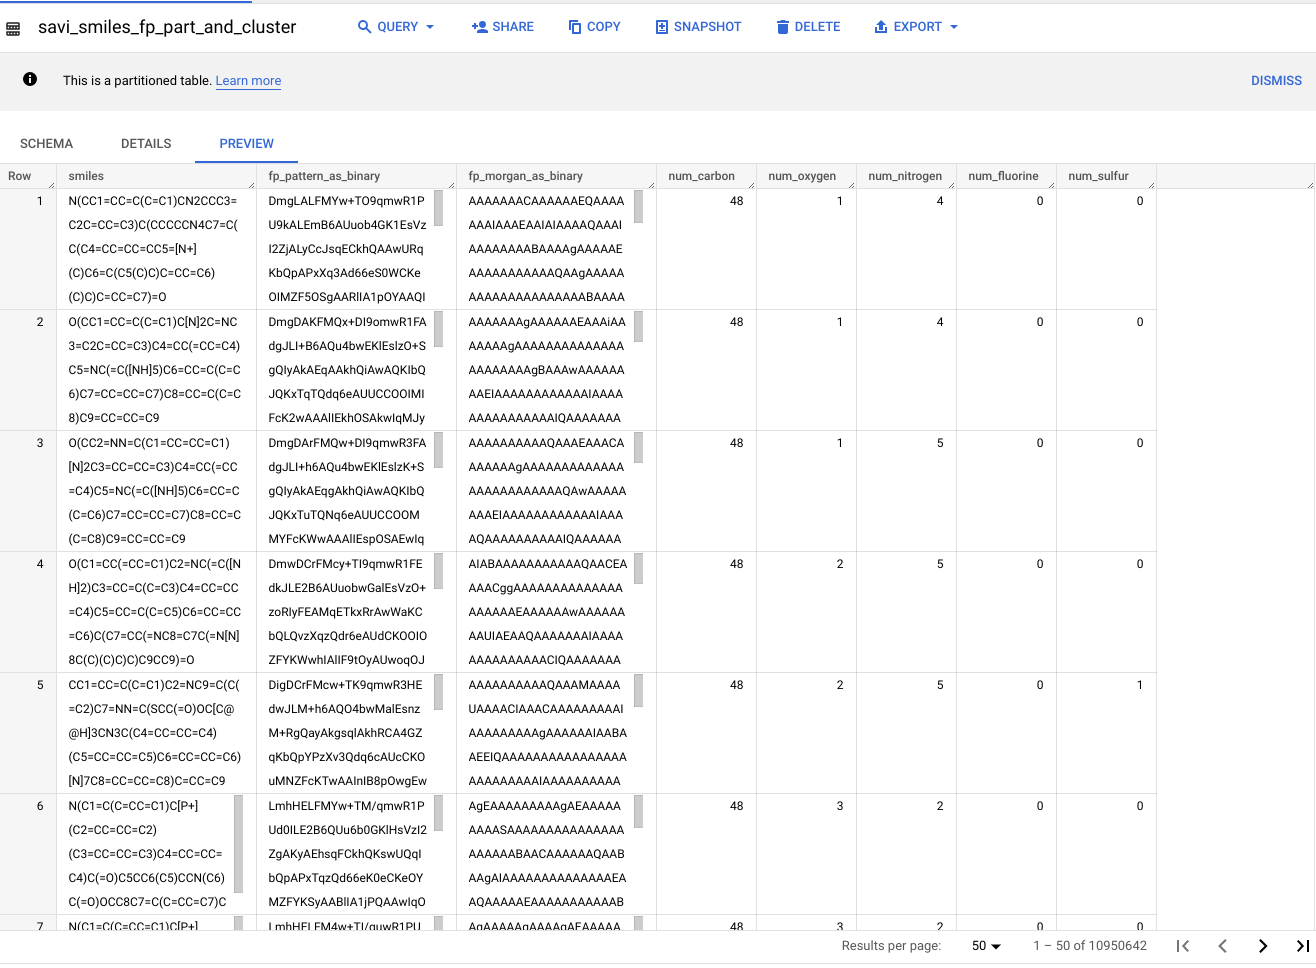

and this is the schema:

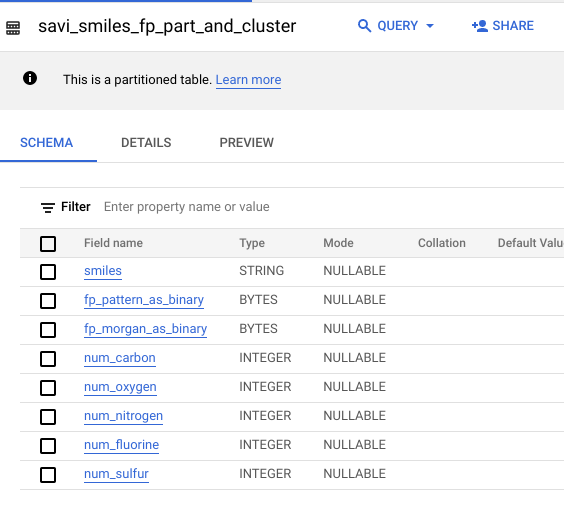

You will see that the fingerprint fields are stored as bytes, but for display purposes in the preview they are shown encoded. 

Because we have partioned and clustered the table, queries can potentially scan much less data. For example, a query like this `SELECT * FROM exports.savi_smiles_fp_part_and_cluster` will scan the entire 12 GB dataset, whereas a query like this `SELECT * FROM exports.savi_smiles_fp_part_and_cluster where num_carbon > 5 and num_carbon < 10` will only scan 53 MB. If you continue adding additional WHERE clauses on the clustered atoms, you may see a further reduction in the number of bytes scanned. 

## Deleting the Intermediate Results

We created two intermediate tables that can be deleted now that we've created our compound registry. 

In [62]:
%%bigquery

drop table if exists exports.savi_smiles;
drop table if exists exports.savi_smiles_fp_json

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 639.96query/s] 


""


## (Optional) Fingerprinting and Molecular Descriptors

You can include molecular descriptors using the **rdkit_molecular_descriptor** function. You can calculate molecular descriptors and  fingerprints in the same query. Below, the maximun number of instances of each functions has been set to 1,000. 

In [33]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE TABLE
  `exports.savi_smiles_fp_md_json` AS (
  SELECT
    smiles,
    `cheminformatics.rdkit_fingerprint`(smiles) AS fingerprint_json,
      `cheminformatics.rdkit_molecular_descriptors`(smiles) AS md_json,
  FROM
    `exports.savi_smiles` );

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1424.37query/s]                        

3min 29s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


That query scans ~ 570 MB and takes about 3.5 minutes. 

To create a registry with fingerprints and molecular descriptors you can run

In [34]:
%%timeit -n 1 -r 1
%%bigquery

CREATE OR REPLACE TABLE
  exports.savi_smiles_fp_md_part_and_cluster
PARTITION BY
  RANGE_BUCKET(num_carbon, GENERATE_ARRAY(0, 100,1))
CLUSTER BY
  num_nitrogen,
  num_oxygen,
  num_fluorine,
  num_sulfur AS
SELECT
  smiles,
  FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_pattern_long_as_binary_hex')) AS fp_pattern_as_binary,
  FROM_HEX(JSON_VALUE(fingerprint_json, '$.fp_morgan_as_binary_hex')) AS fp_morgan_as_binary,
  CAST(JSON_VALUE(fingerprint_json, "$.num_carbon") AS INT64) AS num_carbon,
  CAST(JSON_VALUE(fingerprint_json, "$.num_oxygen") AS INT64) AS num_oxygen,
  CAST(JSON_VALUE(fingerprint_json, "$.num_nitrogen") AS INT64) AS num_nitrogen,
  CAST(JSON_VALUE(fingerprint_json, "$.num_fluorine") AS INT64) AS num_fluorine,
  CAST(JSON_VALUE(fingerprint_json, "$.num_sulfur") AS INT64) AS num_sulfur,
  CAST(JSON_VALUE(md_json, "$.ExactMolWt") as FLOAT64 ) as exact_mol_wt,
  CAST(JSON_VALUE(md_json, "$.FractionCSP3") as FLOAT64 ) as fraction_csp3,
  CAST(JSON_VALUE(md_json, "$.BalabanJ") as FLOAT64 ) as balabanj,
  CAST(JSON_VALUE(md_json, "$.BertzCT") as FLOAT64 ) as bertzct,
  CAST(JSON_VALUE(md_json, "$.HallKierAlpha") as FLOAT64 ) as hallkieralpha,
  CAST(JSON_VALUE(md_json, "$.HeavyAtomMolWt") as FLOAT64 ) as heavy_atom_mol_wt,
  CAST(JSON_VALUE(md_json, "$.MaxAbsPartialCharge") as FLOAT64 ) as max_abs_partial_charge,
  CAST(JSON_VALUE(md_json, "$.MaxPartialCharge") as FLOAT64 ) as max_partial_charge,
  CAST(JSON_VALUE(md_json, "$.MolLogP") as FLOAT64 ) as mol_logp,
  CAST(JSON_VALUE(md_json, "$.MolMR") as FLOAT64 ) as mol_mr,
  CAST(JSON_VALUE(md_json, "$.HeavyAtomCount") as INT64 ) as heavy_atom_count,
  CAST(JSON_VALUE(md_json, "$.NumAliphaticRings") as INT64 ) as num_aliphatic_rings,
  CAST(JSON_VALUE(md_json, "$.NHOHCount") as INT64 ) as nhoh_count,
  CAST(JSON_VALUE(md_json, "$.NOCount") as INT64 ) as no_count,
  CAST(JSON_VALUE(md_json, "$.NumAliphaticCarbocycles") as INT64 ) as num_alpiphatic_carbocycles,
  CAST(JSON_VALUE(md_json, "$.NumAliphaticHeterocycles") as INT64 ) as num_aliphatic_heterocycles,
  CAST(JSON_VALUE(md_json, "$.NumAromaticCarbocycles") as INT64 ) as num_aromatic_carbocycles,
  CAST(JSON_VALUE(md_json, "$.NumAromaticHeterocycles") as INT64 ) as num_aromatic_heterocycles,
  CAST(JSON_VALUE(md_json, "$.NumAromaticRings") as INT64 ) as num_aromatic_rings,
  CAST(JSON_VALUE(md_json, "$.NumHAcceptors") as INT64 ) as num_h_acceptors,
  CAST(JSON_VALUE(md_json, "$.NumHDonors") as INT64 ) as num_h_donors,
  CAST(JSON_VALUE(md_json, "$.NumHeteroatoms") as INT64 ) as num_hetero_atoms,
  CAST(JSON_VALUE(md_json, "$.NumRadicalElectrons") as INT64 ) as num_radical_electrons,
  CAST(JSON_VALUE(md_json, "$.NumRotatableBonds") as INT64 ) as num_rotatable_bonds,
  CAST(JSON_VALUE(md_json, "$.NumSaturatedCarbocycles") as INT64 ) as num_saturated_carbocycles,
  CAST(JSON_VALUE(md_json, "$.NumSaturatedHeterocycles") as INT64 ) as num_saturated_heterocycles,
  CAST(JSON_VALUE(md_json, "$.NumSaturatedRings") as INT64 ) as num_saturated_rings,
  CAST(JSON_VALUE(md_json, "$.NumValenceElectrons") as INT64 ) as num_valence_electrons
FROM
  exports.savi_smiles_fp_md_json
WHERE
  fingerprint_json != "" and md_json != ""

Query complete after 0.00s: 100%|██████████| 5/5 [00:00<00:00, 1915.56query/s]                        

29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The schema for the table looks like this (with some fields cut off)

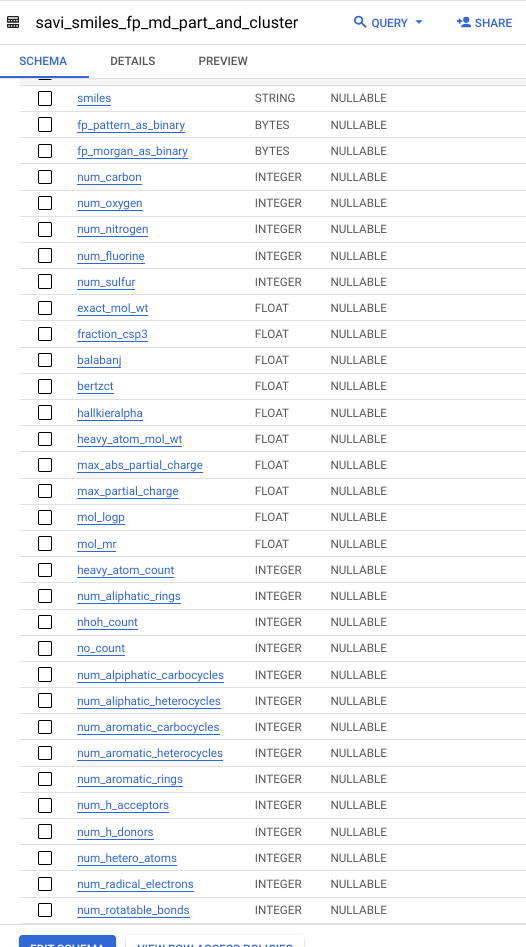

With molecular descriptor data, you can very easily start doing machine learning directly in BigQuery with [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/introduction). You can also combine this data with experimental data to build custom machine learning models. You can create machine learning models using [CREATE MODEL](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create)  across model types ranging from [K-means clustering](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-kmeans), to [Deep Neural Networks](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models), to [Multi-Modal Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm).

We can delete these results now and continue working with the fingerprint table. 

In [36]:
%%bigquery

drop table if exists exports.savi_smiles_fp_md_json;
drop table if exists exports.savi_smiles_fp_md_part_and_cluster;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 836.85query/s] 


""


## Creating Similarity Search

Now that the compound registry has been fingerprinted, we create a stored procedure for similarity searches. You can do this in a number of different ways, but we'll create a search that takes a SMILES string as input, along with a "num_carbon_radius" which defines a lower and upper limit on the number of carbons relative to the search SMILES, and a tolerance for the Tanimoto calculation. 

In [63]:
%%bigquery


CREATE OR REPLACE PROCEDURE
  `cheminformatics.morgan_similarity_radius`(smiles STRING, num_carbon_radius INT64, tolerance FLOAT64)

BEGIN

DECLARE
  json_return STRING;
DECLARE
  morgan_fp BYTES;
DECLARE
  in_num_carbon INT64;

SET
  json_return=`cheminformatics.rdkit_fingerprint`(smiles);
SET
  morgan_fp = FROM_HEX(JSON_VALUE(json_return, "$.fp_morgan_as_binary_hex"));
SET
  in_num_carbon = CAST(JSON_VALUE(json_return, "$.num_carbon") AS INT64);

SELECT
  smiles
FROM
  `exports.savi_smiles_fp_part_and_cluster`
WHERE
  num_carbon IN UNNEST(GENERATE_ARRAY(in_num_carbon-num_carbon_radius, in_num_carbon+num_carbon_radius, 1))
  AND BIT_COUNT(morgan_fp & fp_morgan_as_binary) / BIT_COUNT(morgan_fp | fp_morgan_as_binary) > tolerance;

END;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 811.59query/s] 


""


Once the stored procedure is defined, we can use it to search the registry and capture the result set in a dataframe.

In [42]:
%%timeit -n 1 -r 4
%%bigquery df

CALL `cheminformatics.morgan_similarity_radius`("O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)NC(=O)OCC6C5=C(C=CC=C5)C7=C6C=CC=C7)CC8=CC=CC(=C8)SC", 5, 0.7);

Downloading: 100%|██████████| 5/5 [00:01<00:00,  2.83rows/s]

3.59 s ± 214 ms per loop (mean ± std. dev. of 4 runs, 1 loop each)


In [43]:
print(df.to_string())

                                                                                                                                smiles
0              O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)NC(=O)OCC6C5=C(C=CC=C5)C7=C6C=CC=C7)CC8=CC=CC(=C8)SC
1          O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)NC(=O)OCC6C5=C(C=CC=C5)C7=C6C=CC=C7)CC8=CC=C(OC(C)C)C=C8
2                          O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)NC(=O)OCC6C5=C(C=CC=C5)C7=C6C=CC=C7)CCOC
3  O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)NC(=O)OCC6C5=C(C=CC=C5)C7=C6C=CC=C7)CC8=CC9=C(C=C8)C=CC(=C9)CC#N
4              O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)NC(=O)OCC6C5=C(C=CC=C5)C7=C6C=CC=C7)CC8=C(C)OC(=C8)C


## Visualizing the Result Set as Molecules

To visualize the result set as molecules, install rdkit (which is only needed for this section not for using the remote functions), and define some helper functions. 

In [7]:
!pip install rdkit

In [8]:
from rdkit import Chem
from IPython.display import HTML
from rdkit.Chem import PandasTools

def show_df(df):
    return HTML(df.to_html(notebook=True))

def add_molecule_column(df):
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='m')

In [9]:
add_molecule_column(df)

,smiles,m
0,O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=...,
1,O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=...,
2,O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=...,
3,O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=...,
4,O(C(=O)[C@@H](CC1=C[N](C=N1)C(C2=CC=CC=C2)(C3=...,

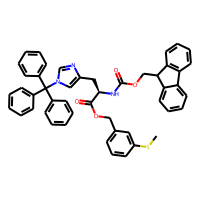
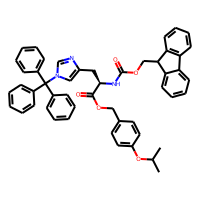
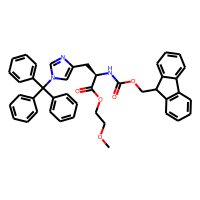
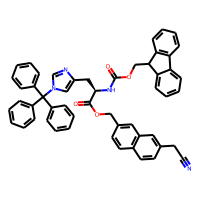
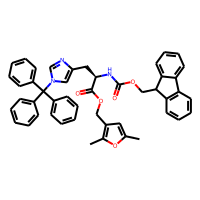

In [10]:
show_df(df)

## Similarity searching across a table of compounds

You can also run similarity searches across sets of compounds (instead of individually using the above stored procedure). To illustrate that, we'll select 10,000 compounds from the registry and then use that as our search set of compounds.

In [38]:
%%bigquery

CREATE OR REPLACE TABLE
  exports.savi_smiles_subset_fp_part_and_cluster
PARTITION BY
  RANGE_BUCKET(num_carbon, GENERATE_ARRAY(0,100,1))
CLUSTER BY
  num_nitrogen,
  num_oxygen,
  num_fluorine,
  num_sulfur AS
SELECT
  *
FROM
  exports.savi_smiles_fp_part_and_cluster
LIMIT
  10000

Query complete after 0.00s: 100%|██████████| 6/6 [00:00<00:00, 2932.74query/s]                        


""


Then we can use the following query to run the Tanimoto Similarity calculation across the datasets. We'll limit the search to compounds that are within $\pm$ 5 carbons of each other and use a similarity of 0.7.  

In [45]:
%%timeit -n 1 -r 2
%%bigquery 

CREATE OR REPLACE TABLE
  `exports.savi_smiles_similarity` AS
SELECT
  savi_subset.smiles AS smiles,
  savi.smiles AS similar_smiles
FROM
  `chem-beta.exports.savi_smiles_subset_fp_part_and_cluster` savi_subset
JOIN
  `exports.savi_smiles_fp_part_and_cluster` savi
ON
  savi_subset.num_carbon IN UNNEST(GENERATE_ARRAY(savi.num_carbon-5, savi.num_carbon+5, 1))
WHERE
  BIT_COUNT(savi_subset.fp_morgan_as_binary & savi.fp_morgan_as_binary) / BIT_COUNT(savi_subset.fp_morgan_as_binary | savi.fp_morgan_as_binary) > 0.7

Query complete after 0.00s: 100%|██████████| 5/5 [00:00<00:00, 2420.26query/s]                        

1min 12s ± 5.72 s per loop (mean ± std. dev. of 2 runs, 1 loop each)


For datasets with many similarity matches, aggegrating similar smiles strings may not be an option because each row can be a maximum of 100MB. In that case, you will need to keep a flat structure (repeated smiles strings per similar smiles string matches) or choose some sort of normalization. For this case, aggregation does work. So as an example, we'll aggregate the table and then select compounds with more than 3 similarity matches. 

In [46]:
%%timeit -n 1 -r 1
%%bigquery 

BEGIN
  
CREATE TEMP TABLE aggregated_similarity_matches AS
 SELECT
   smiles,
   ARRAY_AGG(similar_smiles) AS similar_smiles
 FROM
  `chem-beta.exports.savi_smiles_similarity`
 GROUP BY
  smiles;

CREATE or REPLACE TABLE exports.aggregated_similarity_matches
as
 SELECT
   *
 FROM
  aggregated_similarity_matches
WHERE
  ARRAY_LENGTH(similar_smiles) > 3;

END

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 907.07query/s] 

4.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Here is the preview of the resulting table that shows the similarity matches

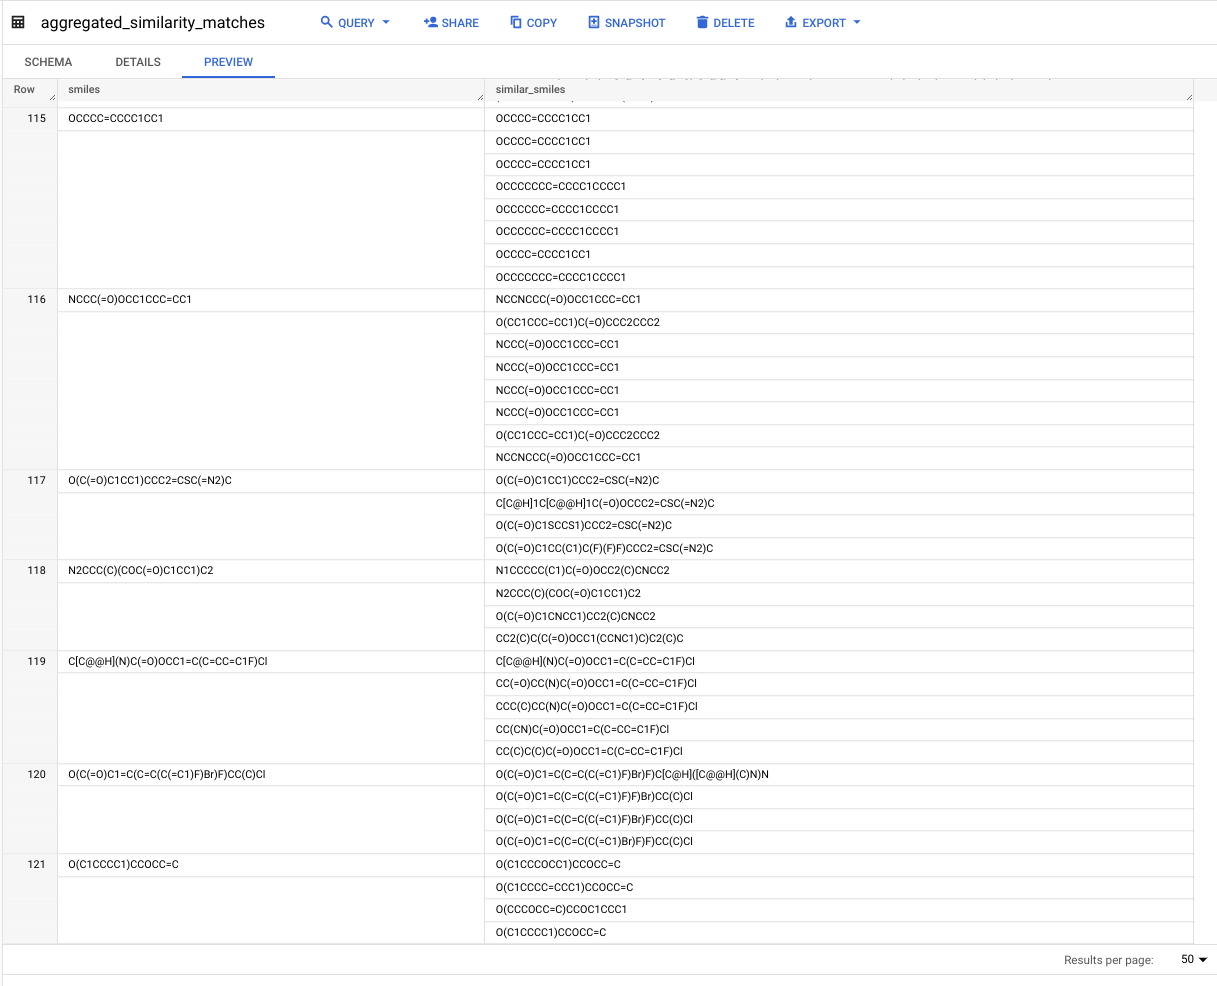

Note: With BigQuery [on-demand pricing](https://cloud.google.com/bigquery/pricing#on_demand_pricing), a query can use up to approximately 256 CPU seconds per MiB of scanned data. If that limit is exceeded, the query will fail with a *billingTierLimitExceeded* error. This can happen when running large-scale data science jobs, ELT jobs over large tables, etc. In that case, consider moving to a [flat rate pricing model](https://cloud.google.com/bigquery/pricing#flat-rate_pricing), including [Flex Slots](https://cloud.google.com/blog/products/data-analytics/optimize-bigquery-costs-with-flex-slots). When running large scale similarity searches, it is possible to exceed the CPU/MiB scanned limits for BigQuery on-demand pricing. This error is triggered because the similarity search calculation is CPU intensive (the bit vector calculation) but it only scans the equivalent of the largest dataset. 

This is an example of what that error would look like in the BigQuery UI

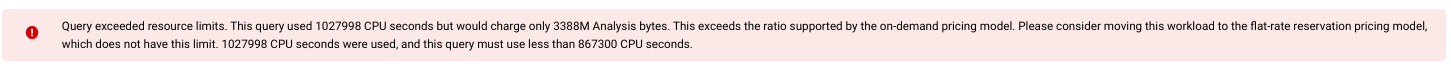

In such a case, consider moving to a [flat rate pricing model](https://cloud.google.com/bigquery/pricing#flat-rate_pricing), including [Flex Slots](https://cloud.google.com/blog/products/data-analytics/optimize-bigquery-costs-with-flex-slots).

Now we can drop the tables we created to illustrate similarity searching across tables of compounds

In [48]:
%%bigquery

drop table if exists exports.savi_smiles_subset_fp_part_and_cluster;
drop table if exists exports.savi_smiles_similarity;
drop table if exists exports.aggregated_similarity_matches;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 841.38query/s] 


""


## Creating Substructure Search

You can optimize substructure searches tailored to your registry. Since this is a substructure query, the number of atoms of each type from the target comound has to be greater than the search fragment, so we can use the number of carbons, nitrogens, oxygens, and fluorines as the first filter. That reduces the total bytes scanned in a simple to implement way. The second filter is based on the pattern fingerprint. To be a candidate for a substructure match it is necessary (but not sufficient) that $\|F_{frag} \land F_{target} \| = \| F_{frag} \| $. The final filter is deterministic graph-based algorithm from the RDKit (implemented as a remote function).

In [13]:
%%bigquery

CREATE OR REPLACE PROCEDURE `cheminformatics.substructure_search`(fragment_smiles STRING)
BEGIN

declare json_return STRING;
declare fragment_num_carbon, fragment_num_nitrogen, fragment_num_oxygen, fragment_num_fluorine, bit_count_fragment INT64;
declare fragment_pattern_fp BYTES;
declare fragment_bit_count INT64;

set json_return=`cheminformatics.rdkit_fingerprint`(fragment_smiles);
set fragment_pattern_fp = FROM_HEX(JSON_VALUE(json_return, "$.fp_pattern_long_as_binary_hex"));
set fragment_num_carbon = CAST(JSON_VALUE(json_return, "$.num_carbon") as INT64);
set fragment_num_oxygen = CAST(JSON_VALUE(json_return, "$.num_oxygen") as INT64);
set fragment_num_nitrogen = CAST(JSON_VALUE(json_return, "$.num_nitrogen") as INT64);
set fragment_num_fluorine = CAST(JSON_VALUE(json_return, "$.num_fluorine") as INT64);
set fragment_bit_count = bit_count(fragment_pattern_fp);

select smiles from `exports.savi_smiles_fp_part_and_cluster`
where
num_carbon >= fragment_num_carbon and
num_nitrogen >= fragment_num_nitrogen and
num_oxygen >= fragment_num_oxygen and
num_fluorine >= fragment_num_fluorine and
bit_count(fragment_pattern_fp & fp_pattern_as_binary) = fragment_bit_count
and
`cheminformatics.rdkit_substructure_match`(fragment_smiles, smiles);
END;

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1004.62query/s]


""


In [35]:
%%timeit -n 1 -r 1
%%bigquery df

CALL `cheminformatics.substructure_search`("C(C)C1=CC(=C(C=C1)OC2=CC(=CC=C2)C=C)");

Downloading: 100%|██████████| 20/20 [00:01<00:00, 10.24rows/s]

6.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [36]:
df

,smiles
0,CC(C)C1=CC(=C(C=C1)OC2=CC(=CC=C2)C=C)C(C)C
1,O(C1=CC(=CC=C1)C=C)C2=CC=C(C=C2)C(=O)CC(=O)C3=...
2,CC1(C)OB(OC1(C)C)C=CC2=CC(=CC=C2)OC3=CC=C4C(=C...
3,CC1=C(C=C(C=C1)OC2=CC=C(C=C2)C(=O)CC3=NNC(C=C3...
4,CC(=O)C1=CC=C(C=C1)OC2=CC(=CC=C2)C=C
5,COC1=C(C=C(C=C1)C=C)OC2=CC=C(C(CC(C)=O)=O)C=C2
6,OC(=O)C=CC1=CC(=CC=C1)OC3=CC2=C(C(CCO2)=O)C=C3C
7,OC(=O)C=CC1=CC(=CC=C1)OC2=CC(=C(C=C2OC)C(=O)C)OC
8,COC(=O)C=CC1=CC(=C(C=C1)OC)OC2=CC=C(C(=C2Cl)F)...
9,CC1=C(C=C(C=C1)OC2=CC=C(C(=C2Cl)F)C(=O)C(F)(F)...


In [37]:
add_molecule_column(df)

,smiles,m
0,CC(C)C1=CC(=C(C=C1)OC2=CC(=CC=C2)C=C)C(C)C,
1,O(C1=CC(=CC=C1)C=C)C2=CC=C(C=C2)C(=O)CC(=O)C3=...,
2,CC1(C)OB(OC1(C)C)C=CC2=CC(=CC=C2)OC3=CC=C4C(=C...,
3,CC1=C(C=C(C=C1)OC2=CC=C(C=C2)C(=O)CC3=NNC(C=C3...,
4,CC(=O)C1=CC=C(C=C1)OC2=CC(=CC=C2)C=C,
5,COC1=C(C=C(C=C1)C=C)OC2=CC=C(C(CC(C)=O)=O)C=C2,
6,OC(=O)C=CC1=CC(=CC=C1)OC3=CC2=C(C(CCO2)=O)C=C3C,
7,OC(=O)C=CC1=CC(=CC=C1)OC2=CC(=C(C=C2OC)C(=O)C)OC,
8,COC(=O)C=CC1=CC(=C(C=C1)OC)OC2=CC=C(C(=C2Cl)F)...,
9,CC1=C(C=C(C=C1)OC2=CC=C(C(=C2Cl)F)C(=O)C(F)(F)...,

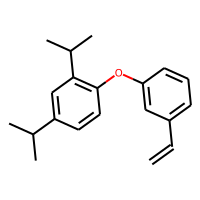
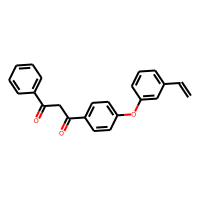
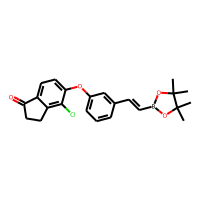
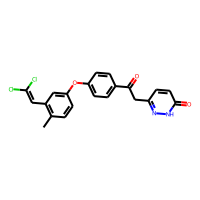
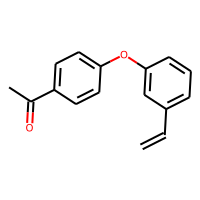
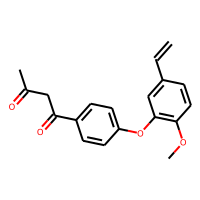
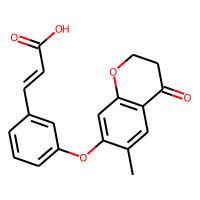
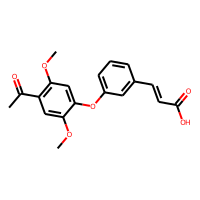
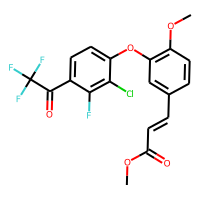
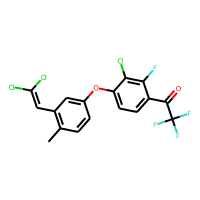
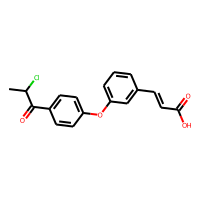
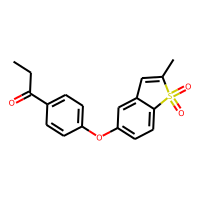
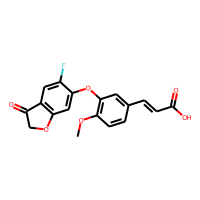
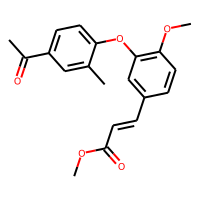
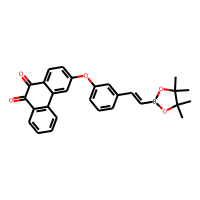
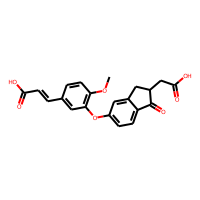
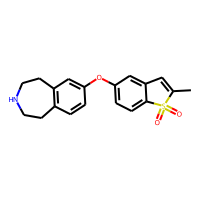
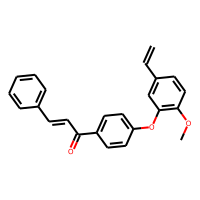
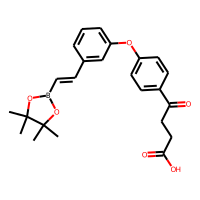
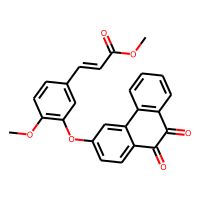

In [38]:
show_df(df)